In [49]:
import sys
!{sys.executable} -m pip install matplotlib seaborn scikit-learn joblib pandas numpy



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
import joblib

In [51]:
#  Load the Dataset
df = pd.read_csv('fingerprint_diabetes_dataset.csv')
df = df.drop('ID', axis=1)

In [52]:
#  Encode Categorical Data
le_fingerprint = LabelEncoder()
df['Fingerprint_Type'] = le_fingerprint.fit_transform(df['Fingerprint_Type'])
joblib.dump(le_fingerprint, 'model/le_fingerprint.pkl')

le_family_history = LabelEncoder()
df['Family_History'] = le_family_history.fit_transform(df['Family_History'])
joblib.dump(le_family_history, 'model/le_family_history.pkl')

le_diabetes_risk = LabelEncoder()
df['Diabetes_Risk'] = le_diabetes_risk.fit_transform(df['Diabetes_Risk'])
joblib.dump(le_diabetes_risk, 'model/le_diabetes_risk.pkl')

['model/le_diabetes_risk.pkl']

In [53]:
#  Features and Labels
X = df[['Fingerprint_Type', 'Ridge_Count', 'Age', 'BMI', 'Family_History']]
y = df['Diabetes_Risk']

In [54]:
#  Add slight noise to numeric features (to make it more realistic)
X_noisy = X.copy()
numeric_cols = ['Ridge_Count', 'Age', 'BMI']
for col in numeric_cols:
    # Add small random noise to reduce overfitting
    X_noisy[col] = X_noisy[col] + np.random.normal(0, 0.5, size=X_noisy.shape[0])

#  Train-Test Split (slightly larger test size + different random seed)
X_train, X_test, y_train, y_test = train_test_split(
    X_noisy, y, test_size=0.25, stratify=y, random_state=15
)

#  Train a less complex Random Forest to reduce overfitting
model = RandomForestClassifier(
    n_estimators=80,        # fewer trees (was 100)
    max_depth=6,            # limit tree depth
    min_samples_split=6,    # require more samples to split
    min_samples_leaf=3,     # require more samples per leaf
    max_features='sqrt',    # use fewer features per tree
    random_state=42
)
model.fit(X_train, y_train)

,n_estimators,80
,criterion,'gini'
,max_depth,6
,min_samples_split,6
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
#  Save the model
joblib.dump(model, 'model/diabetes_model.pkl')


['model/diabetes_model.pkl']

In [56]:
#  Model Accuracy
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f" Model Accuracy: {acc:.2f}")

 Model Accuracy: 0.95


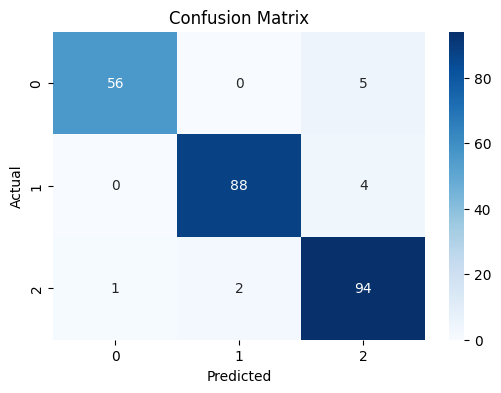

In [57]:
#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

 Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.92      0.95        61
         low       0.98      0.96      0.97        92
      medium       0.91      0.97      0.94        97

    accuracy                           0.95       250
   macro avg       0.96      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250



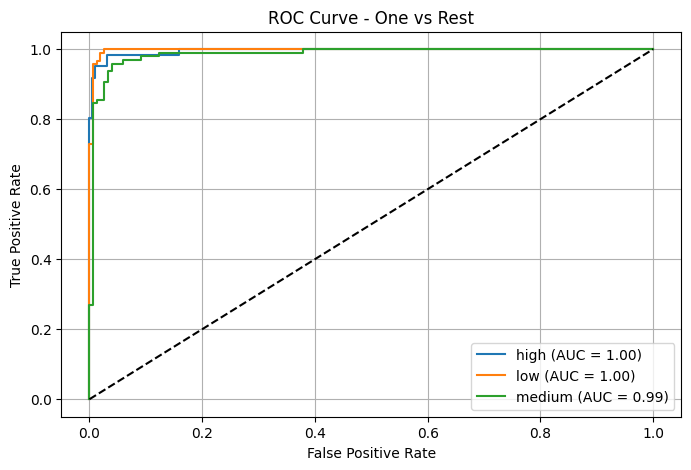

In [58]:
#  Classification Report
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_diabetes_risk.classes_))

#  ROC Curve (one vs rest)
y_test_bin = pd.get_dummies(y_test, columns=le_diabetes_risk.classes_)
y_pred_prob = model.predict_proba(X_test)

plt.figure(figsize=(8, 5))
for i, class_name in enumerate(le_diabetes_risk.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin.iloc[:, i], y_pred_prob[:, i])
    auc = roc_auc_score(y_test_bin.iloc[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - One vs Rest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

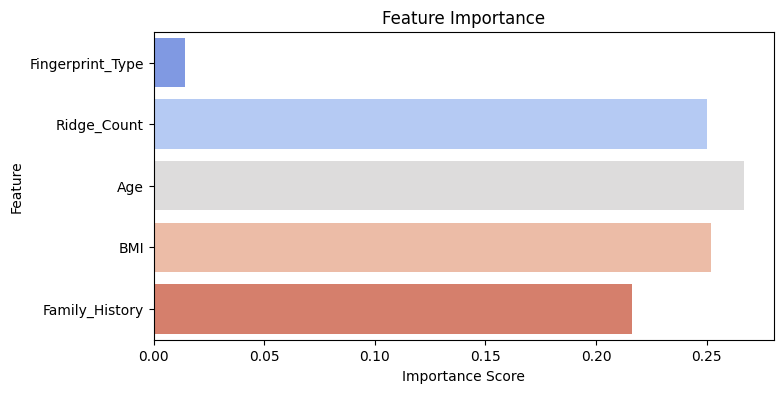

In [59]:
#  Feature Importance
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names, hue=feature_names, palette='coolwarm', legend=False)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

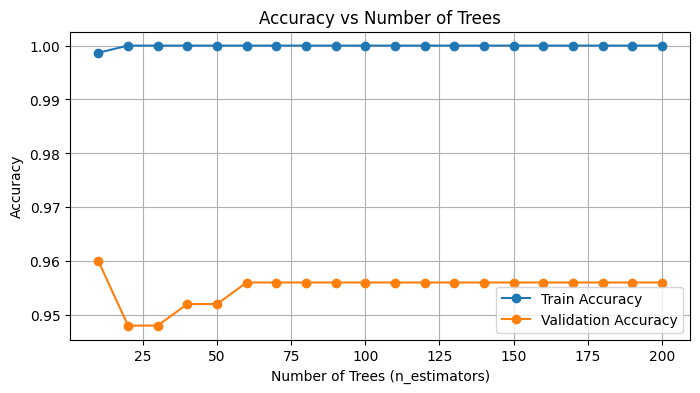

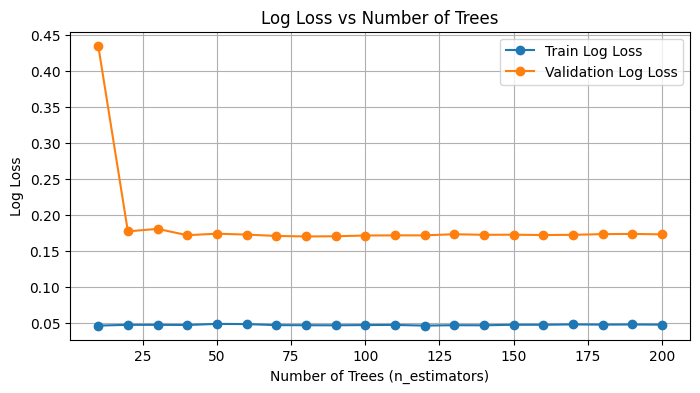

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore")

#  Setup for Accuracy and Log Loss Tracking
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

n_estimators_range = list(range(10, 201, 10))  # Train from 10 to 200 trees

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)

    # Predict for accuracy
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)

    # Predict proba for log loss
    train_proba = model.predict_proba(X_train)
    val_proba = model.predict_proba(X_test)

    train_acc = accuracy_score(y_train, train_preds)
    val_acc = accuracy_score(y_test, val_preds)

    train_log_loss = log_loss(y_train, train_proba)
    val_log_loss = log_loss(y_test, val_proba)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_log_loss)
    val_loss_list.append(val_log_loss)

#  Accuracy Plot
plt.figure(figsize=(8, 4))
plt.plot(n_estimators_range, train_acc_list, label='Train Accuracy', marker='o')
plt.plot(n_estimators_range, val_acc_list, label='Validation Accuracy', marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Trees")
plt.legend()
plt.grid(True)
plt.show()

#  Loss Plot
plt.figure(figsize=(8, 4))
plt.plot(n_estimators_range, train_loss_list, label='Train Log Loss', marker='o')
plt.plot(n_estimators_range, val_loss_list, label='Validation Log Loss', marker='o')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Log Loss")
plt.title("Log Loss vs Number of Trees")
plt.legend()
plt.grid(True)
plt.show()